In [31]:
# NN related libraries
import torch 
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import sys 
sys.path.append('./')

# from the code 
from model.GAT import GAT
from utils.layers import GAT_layer

# data related 
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import time
import os

import numpy as np



In [28]:
dataset_name='Citeseer'
dataset = Planetoid(root=f'/tmp/{datasetname}', name=datasetname,transform=T.NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Citeseer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


In [3]:
edge_index=dataset[0].edge_index
nodes_features=dataset[0].x
nodes_labels=dataset[0].y

#parameters_GAT_network={'num_features_per_layer'={}}



In [32]:
def plot_degree_distributions(edge_index, num_of_nodes, dataset_name):

    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input degrees and output degrees
    in_degrees = np.zeros(num_of_nodes, dtype=np.intc)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        target_node_id = edge_index[1, cnt]
        in_degrees[target_node_id] += 1  

    hist = np.zeros(np.max(in_degrees) + 1)
    for in_degree in in_degrees:
        hist[in_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('degree count'); plt.title(f'Degree for different node ids in {dataset_name}')

    plt.subplot(312)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given degree') 
    plt.title(f'Node degree distribution for {dataset_name}')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

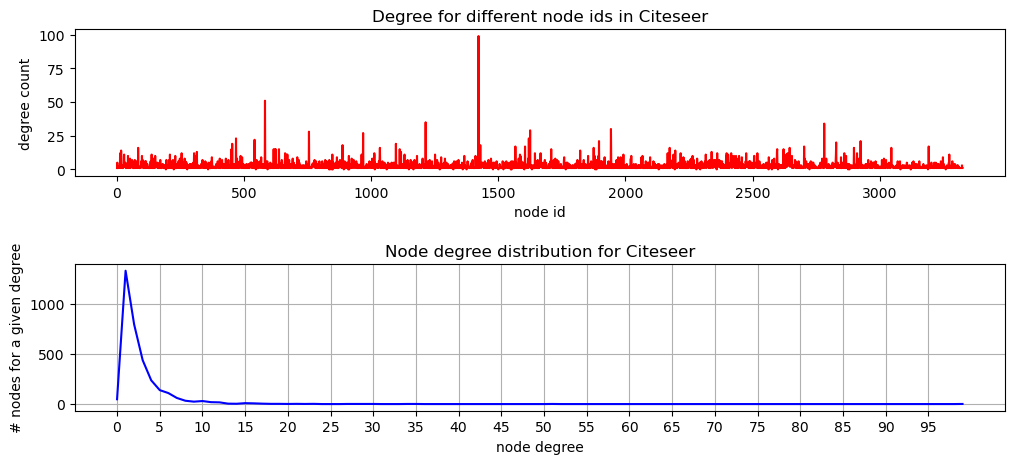

In [33]:
num_of_nodes = len(nodes_labels)
plot_degree_distributions(edge_index, num_of_nodes, dataset_name)

## Training the network in the cora dataset

### First we define the hyperparameters of the network

In [11]:
C=6 # number of classes of the citeseer dataset
params_network={'num_layers':2,
               'num_nodes':nodes_features.shape[0],
                'num_features_per_layer':[nodes_features.shape[1],8,C],
                'num_heads_per_layer':[8,1],
                 'num_epochs':500
               }


### Divide the dataset in training, validation and test

In [5]:
# indices of each set according to the masks given in the dataset (i.e we use the same assignation as in the original paper)
training_set_indices=(dataset[0].train_mask).nonzero(as_tuple=False).flatten()
test_set_indices=(dataset[0].test_mask).nonzero(as_tuple=False).flatten()
val_set_indices=(dataset[0].val_mask).nonzero(as_tuple=False).flatten()
print('The training dataset starts in node {:} and comprises {:} nodes'.format(training_set_indices[0].numpy(),training_set_indices.shape[0]))
print('The validation dataset starts in node {:} and comprises {:} nodes'.format(test_set_indices[0].numpy(),test_set_indices.shape[0]))
print('The test dataset starts in node {:} and comprises {:} nodes'.format(val_set_indices[0].numpy(),val_set_indices.shape[0]))


The training dataset starts in node 0 and comprises 120 nodes
The validation dataset starts in node 2312 and comprises 1000 nodes
The test dataset starts in node 120 and comprises 500 nodes


In [7]:
#Extract the labels for the training set
nodes_labels_training_set=nodes_labels.index_select(0,training_set_indices)
#validation
nodes_labels_validation_set=nodes_labels.index_select(0,val_set_indices)
#test
nodes_labels_test_set=nodes_labels.index_select(0,test_set_indices)

Now we have everything we need in order to start the training process. Let's define the model and run the learning process

In [8]:
# Let's run the training loop 
def train_gat(params_network,num_epochs=40,val_lapse=50,perform_test='True',starting_epoch=0,):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device=torch.device('mps')
    time_start=time.time()
    model_gat=GAT(params_network['num_layers'],params_network['num_nodes'],params_network['num_features_per_layer'],params_network['num_heads_per_layer']).to(device)
    
    loss_fn = nn.CrossEntropyLoss(reduction='mean').to(device)
    optimizer = Adam(model_gat.parameters(), lr=5e-3,weight_decay=5e-4) # weight decay corresponds to the L2 penalty, which in the original implementation is chosen to the value we put here
    
    #nodes_features_dev=nodes_features.to(device)
    #edge_index_dev=edge_index.to(device)
    graph_data=(nodes_features,edge_index)
    
    #nodes_labels_training_set_dev=nodes_labels_training_set.to(device)
    #nodes_labels_validation_set_dev=nodes_labels_validation_set.to(device)
    #nodes_labels_test_set_dev=nodes_labels_test_set.to(device)
    
    #training_set_indices_dev=training_set_indices.to(device)
    #test_set_indices_dev=test_set_indices.to(device)
    #val_set_indices_dev=val_set_indices.to(device)
    
    if starting_epoch!=0:
        trained=torch.load(os.path.join(os.path.dirname('model'), 'model','saved_model','model_gat_trained.pt'))
        model_gat.state_dict=trained['state_dict']
    #TensorBoard summary writter 
    writer=SummaryWriter()
    
    for epoch in range(starting_epoch,num_epochs):
        
        #print(epoch)
        
        model_gat.train() #set model in training mode
        
        #print(next(model_gat.parameters()).device)
        # We do a forward pass of the model and extract the unnormalized logits for the training set 
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_out_train = model_gat(graph_data)[0].index_select(0,training_set_indices)
        
        #print(nodes_unnormalized_out_train.device)
        #print(nodes_unnormalized_out_train.shape)
        loss=loss_fn(nodes_unnormalized_out_train,nodes_labels_training_set)
        
        #Optimizer backward evaluation
        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        
        # Compute the accuracy

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        predictions = torch.argmax(nodes_unnormalized_out_train, dim=-1)
        accuracy = torch.sum(torch.eq(predictions, nodes_labels_training_set).long()).item() / len(nodes_labels_training_set)
        
        
        
        writer.add_scalar('Loss/train',loss.item(),epoch)
        writer.add_scalar('Accuracy/train',accuracy,epoch)
        
        #print(f'time elapsed={(time.time()-time_start):.2f} [s]')
        #print(f'accuracy train={accuracy:.3f}')
        if (epoch+1)%val_lapse==0:
            with torch.no_grad():
                model_gat.eval()
                nodes_unnormalized_out_val = model_gat(graph_data)[0].index_select(0,val_set_indices)
                loss_val=loss_fn(nodes_unnormalized_out_val,nodes_labels_validation_set)
                predictions = torch.argmax(nodes_unnormalized_out_val, dim=-1)
                accuracy = torch.sum(torch.eq(predictions, nodes_labels_validation_set).long()).item() / len(nodes_labels_validation_set)
        
                
                writer.add_scalar('Loss/validation',loss_val.item(),epoch)
                writer.add_scalar('Accuracy/validation',accuracy,epoch)
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')
            torch.save(model_gat,os.path.join(os.path.dirname('model'), 'model','saved_model',f'model_gat_citeseer_trained_epoch_{epoch+1}_.pt'))
    
    if perform_test:
        with torch.no_grad():
            model_gat.eval()
            nodes_unnormalized_out_test = model_gat(graph_data)[0].index_select(0,test_set_indices)
            loss_test=loss_fn(nodes_unnormalized_out_test,nodes_labels_test_set)
            predictions = torch.argmax(nodes_unnormalized_out_test, dim=-1)
            accuracy = torch.sum(torch.eq(predictions, nodes_labels_test_set).long()).item() / len(nodes_labels_test_set)
        print(f'Test accuracy = {accuracy}')
    torch.save(model_gat,os.path.join(os.path.dirname('model'), 'model','saved_model','model_gat_citeseer_trained.pt'))
    writer.close()
        
        

        


        
        
    
    
    
    
    

In [12]:
train_gat(params_network,starting_epoch=0,num_epochs=2000,val_lapse=100)

GAT training: time elapsed= 8.96 [s] | epoch=100 | val acc=0.48
GAT training: time elapsed= 17.69 [s] | epoch=200 | val acc=0.546
GAT training: time elapsed= 26.39 [s] | epoch=300 | val acc=0.644
GAT training: time elapsed= 35.33 [s] | epoch=400 | val acc=0.716
GAT training: time elapsed= 44.10 [s] | epoch=500 | val acc=0.718
GAT training: time elapsed= 52.89 [s] | epoch=600 | val acc=0.702
GAT training: time elapsed= 61.77 [s] | epoch=700 | val acc=0.704
GAT training: time elapsed= 70.61 [s] | epoch=800 | val acc=0.714
GAT training: time elapsed= 79.41 [s] | epoch=900 | val acc=0.722
GAT training: time elapsed= 88.18 [s] | epoch=1000 | val acc=0.714
GAT training: time elapsed= 96.96 [s] | epoch=1100 | val acc=0.71
GAT training: time elapsed= 105.85 [s] | epoch=1200 | val acc=0.712
GAT training: time elapsed= 114.72 [s] | epoch=1300 | val acc=0.708
GAT training: time elapsed= 123.48 [s] | epoch=1400 | val acc=0.704
GAT training: time elapsed= 132.41 [s] | epoch=1500 | val acc=0.706
GAT

In [13]:
model_gat=torch.load(os.path.join(os.path.dirname('model'), 'model','saved_model','model_gat_trained.pt'))

In [15]:
model_gat.eval()
with torch.no_grad():
    features_out_citeeser=model_gat((nodes_features,edge_index))[0]

In [16]:
features_out_citeeser.numpy()

array([[0.0866792 , 0.10579642, 0.12838882, 0.52289194, 0.06513186,
        0.09111171],
       [0.10946176, 0.4663667 , 0.18822047, 0.07435515, 0.06569319,
        0.09590276],
       [0.04883076, 0.03249908, 0.04525184, 0.03779919, 0.05548564,
        0.7801334 ],
       ...,
       [0.06119397, 0.14041921, 0.45921218, 0.19059694, 0.05175687,
        0.09682086],
       [0.23533393, 0.28885552, 0.13651945, 0.09911223, 0.11791454,
        0.12226433],
       [0.16200307, 0.12948242, 0.10857455, 0.10290402, 0.0820113 ,
        0.41502467]], dtype=float32)

In [17]:
from sklearn.manifold import TSNE

In [18]:
embeddings=TSNE(n_components=2,perplexity=30,method='barnes_hut',learning_rate=1000).fit_transform(features_out_citeeser.numpy())

In [19]:
import matplotlib.pyplot as plt

In [20]:
cora_colors=['red','blue','green','purple','orange','yellow']

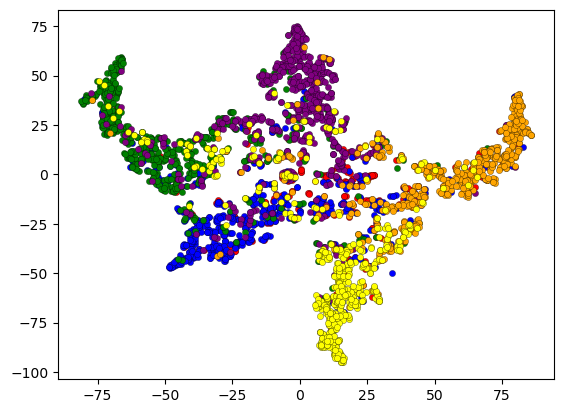

In [21]:
for c in range(6):
    plt.scatter(embeddings[nodes_labels==c,0],embeddings[nodes_labels==c,1],color=cora_colors[c],edgecolors='black',linewidth=0.2,s=20)
plt.show()

In [22]:
plt.scatter?

In [23]:
modules = dict(model_gat.named_modules())


In [24]:
scores_layer_1=modules['gat_network.0'].attention_scores[:,0,0]
scores_layer_2=modules['gat_network.1'].attention_scores[:,0,0]

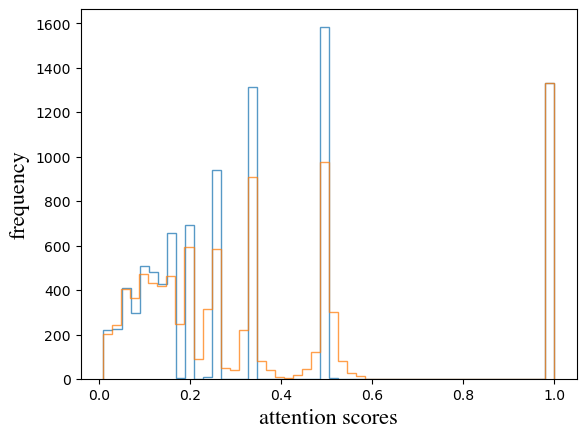

In [27]:
plt.hist(scores_layer_1, 50, density=False, facecolor='g', alpha=0.75,histtype=u'step')
plt.hist(scores_layer_2, 50, density=False, facecolor='b', alpha=0.75,histtype=u'step')
plt.xlabel('attention scores',fontsize='16',fontfamily='Times')
plt.ylabel('frequency',fontsize='16',fontfamily='Times')
plt.show()